In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

import optuna

import lime.lime_tabular as lime_tabular
import shap

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid", palette="viridis")


In [3]:
movies = pd.read_csv("tmdb_5000_movies.csv")
credits = pd.read_csv("tmdb_5000_credits.csv")

credits = credits.rename(columns={"movie_id": "id"})
df = movies.merge(credits, on="id")

In [4]:
df_clean = df[[
    "budget", "popularity", "vote_average", "vote_count",
    "revenue", "runtime"
]].replace(0, np.nan).dropna()

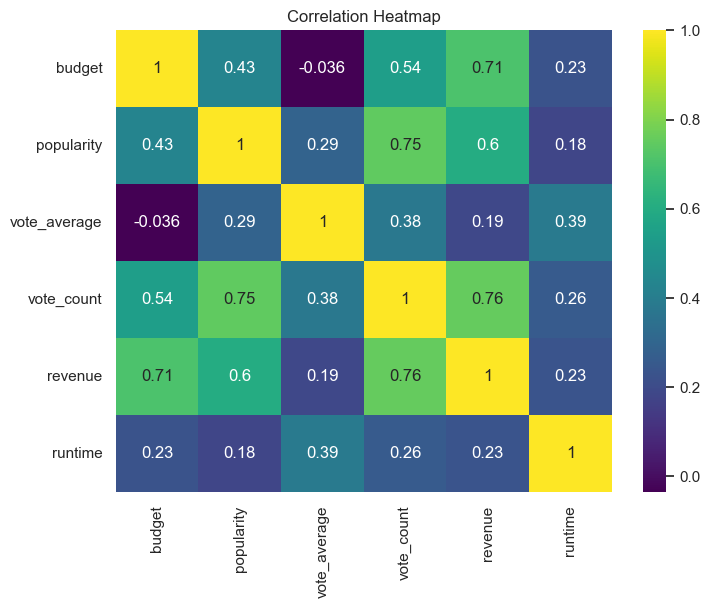

In [5]:
plt.figure(figsize=(8,6))
sns.heatmap(df_clean.corr(), annot=True, cmap="viridis")
plt.title("Correlation Heatmap")
plt.show()

In [6]:
fig = px.scatter(
    df_clean, x="budget", y="revenue",
    color="vote_average", size="popularity",
    title="Budget vs Revenue (colored by rating)"
)
fig.show()

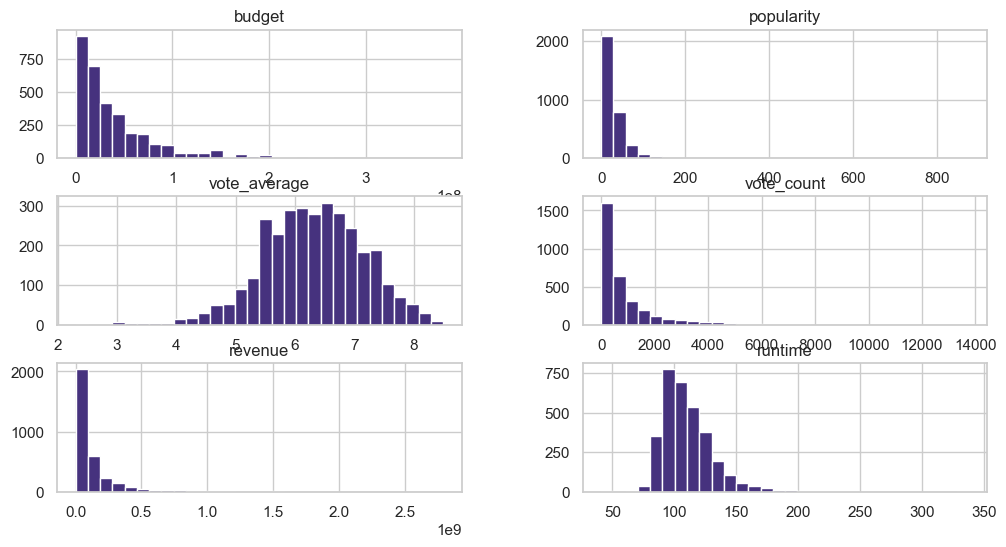

In [7]:
df_clean.hist(figsize=(12,6), bins=30)
plt.show()

In [8]:
X = df_clean.drop("revenue", axis=1)
y = df_clean["revenue"]

num_features = X.columns.tolist()

In [9]:
preprocess = ColumnTransformer(
    [("num", StandardScaler(), num_features)]
)

model = RandomForestRegressor(random_state=42)

pipe = Pipeline([
    ("prep", preprocess),
    ("model", model)
])

In [10]:
pd.DataFrame([
    ["n_estimators", "количество деревьев"],
    ["max_depth", "максимальная глубина дерева"],
    ["min_samples_split", "минимум выборок для разбиения"],
    ["min_samples_leaf", "минимум выборок в листе"],
    ["max_features", "фичи для выбора лучшего split"]
], columns=["Гиперпараметр", "Описание"])

,Гиперпараметр,Описание
0,n_estimators,количество деревьев
1,max_depth,максимальная глубина дерева
2,min_samples_split,минимум выборок для разбиения
3,min_samples_leaf,минимум выборок в листе
4,max_features,фичи для выбора лучшего split


In [11]:
grid_params = {
    "model__n_estimators": [100, 300],
    "model__max_depth": [5, 10, None],
    "model__min_samples_split": [2, 4]
}

grid = GridSearchCV(pipe, grid_params, cv=3, n_jobs=-1)
grid.fit(X, y)

grid.best_params_


{'model__max_depth': 10,
 'model__min_samples_split': 5,
 'model__n_estimators': 300}

In [12]:
rand_params = {
    "model__n_estimators": [50, 100, 200, 400],
    "model__max_depth": [5, 10, 15, None],
    "model__min_samples_split": [2, 5, 10]
}

random = RandomizedSearchCV(pipe, rand_params, n_iter=10, cv=3, n_jobs=-1)
random.fit(X, y)

random.best_params_

{'model__n_estimators': 400,
 'model__min_samples_split': 10,
 'model__max_depth': 10}

In [13]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 400),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10)
    }

    pipe.set_params(
        model__n_estimators=params["n_estimators"],
        model__max_depth=params["max_depth"],
        model__min_samples_split=params["min_samples_split"]
    )

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_val)

    return mean_squared_error(y_val, pred)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)

study.best_params


[I 2025-11-29 11:04:47,141] A new study created in memory with name: no-name-a58e63ca-1c90-4b0f-9041-aa6fed8ba228
[I 2025-11-29 11:04:49,036] Trial 0 finished with value: 9309635036351882.0 and parameters: {'n_estimators': 162, 'max_depth': 7, 'min_samples_split': 4}. Best is trial 0 with value: 9309635036351882.0.
[I 2025-11-29 11:04:51,727] Trial 1 finished with value: 1.0204776330081368e+16 and parameters: {'n_estimators': 175, 'max_depth': 10, 'min_samples_split': 4}. Best is trial 0 with value: 9309635036351882.0.
[I 2025-11-29 11:04:55,966] Trial 2 finished with value: 9901763317235450.0 and parameters: {'n_estimators': 230, 'max_depth': 17, 'min_samples_split': 6}. Best is trial 0 with value: 9309635036351882.0.
[I 2025-11-29 11:04:57,120] Trial 3 finished with value: 1.1283966395232358e+16 and parameters: {'n_estimators': 106, 'max_depth': 6, 'min_samples_split': 4}. Best is trial 0 with value: 9309635036351882.0.
[I 2025-11-29 11:05:04,880] Trial 4 finished with value: 8992154

{'n_estimators': 284, 'max_depth': 22, 'min_samples_split': 8}

In [14]:
best_pipe = grid.best_estimator_
best_pipe.fit(X, y)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['budget', 'popularity',
                                                   'vote_average', 'vote_count',
                                                   'runtime'])])),
                ('model',
                 RandomForestRegressor(max_depth=10, min_samples_split=5,
                                       n_estimators=300, random_state=42))])

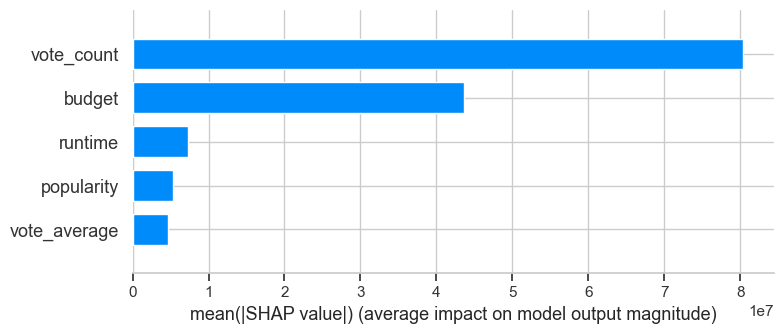

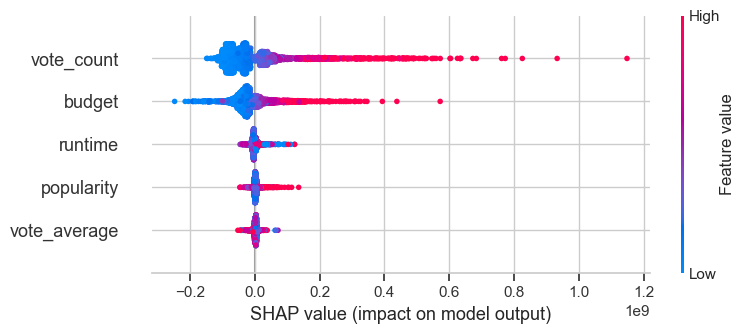

In [15]:
explainer = shap.TreeExplainer(best_pipe.named_steps["model"])
X_transformed = best_pipe.named_steps["prep"].transform(X)
shap_values = explainer.shap_values(X_transformed)

shap.summary_plot(shap_values, X, plot_type="bar")
shap.summary_plot(shap_values, X)


In [24]:
def pipe_predict_from_lime(x):
    df_temp = pd.DataFrame(x, columns=num_features)
    return best_pipe.predict(df_temp)

lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_transformed,
    feature_names=num_features,
    mode="regression"
)

i = 0

exp = lime_explainer.explain_instance(
    X_transformed[i],
    pipe_predict_from_lime,  
)

def plot_lime_explanation(exp):
    """
    Рисуем красивую визуализацию вкладов LIME.
    """
    import matplotlib.pyplot as plt
    
    exp_list = exp.as_list()
    lime_df = pd.DataFrame(exp_list, columns=["Feature", "Contribution"])

    # сокращение длинных текстов
    lime_df["Feature"] = lime_df["Feature"].apply(lambda x: x.split(" ")[0])

    # сортировка по величине вклада
    lime_df = lime_df.sort_values("Contribution", ascending=True)

    # цвета: отрицательные - оранжевые, положительные - голубые
    colors = lime_df["Contribution"].apply(lambda x: "#ff8c00" if x < 0 else "#1f77b4")

    plt.figure(figsize=(8, 4))
    plt.barh(lime_df["Feature"], lime_df["Contribution"], color=colors)
    plt.axvline(0, color="black", linewidth=1)
    plt.title("LIME Feature Contributions", fontsize=14)
    plt.xlabel("Contribution to prediction")
    plt.tight_layout()
    plt.show()


---- PREDICTED REVENUE ----
204,767,901 $


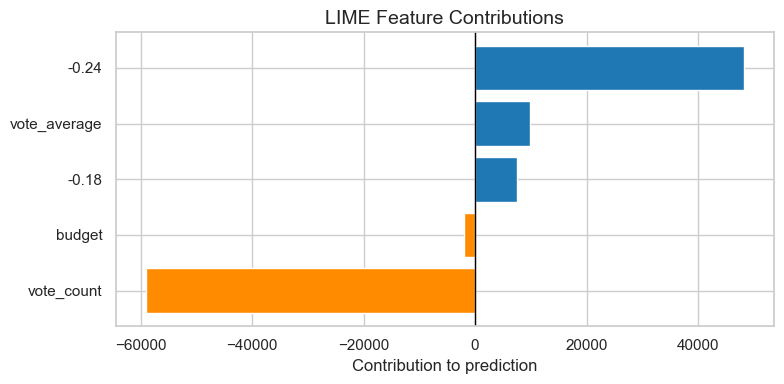

In [23]:
def pipe_predict_from_lime(x):
    df_temp = pd.DataFrame(x, columns=num_features)
    return best_pipe.predict(df_temp)
def movie_predict(budget, popularity, vote_avg, vote_cnt, runtime):

    x = pd.DataFrame([{
        "budget": budget,
        "popularity": popularity,
        "vote_average": vote_avg,
        "vote_count": vote_cnt,
        "runtime": runtime
    }])

    pred = best_pipe.predict(x)[0]

    x_t = best_pipe.named_steps["prep"].transform(x)

    exp = lime_explainer.explain_instance(
        x_t[0],
        pipe_predict_from_lime
    )

    print("---- PREDICTED REVENUE ----")
    print(f"{pred:,.0f} $")

    # вызываем красивый график
    plot_lime_explanation(exp)

    return exp


exp = movie_predict(100_000_000, 30, 7.2, 2000, 120)
exp.show_in_notebook()
